In [9]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Praj83351@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/HP/OneDrive/Desktop/project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db =mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Praj83351@",
                            database= "ecommerce" )

cur = db.cursor()


# 1. List `all unique cities` where `customers` are located.

In [73]:
query = """ select distinct(upper(customer_city))
from customers
"""

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data,columns=["City"])
df.head()


,City
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS


In [74]:
df.tail()

,City
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL
4118,EUGENIO DE CASTRO


# 2. Count the number of orders placed in `2017`.

In [18]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data= cur.fetchall()
"Total orders placed in 2017 are",data[0][0]

('Total orders placed in 2017 are:-', 45101)

# 3. Find the `total sales` per category.

In [43]:
query = """  select upper(products.product_category),
round(sum(payments.payment_value),2)    
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id =order_items.order_id
group by product_category 
"""
cur.execute(query)
data = cur.fetchall()


df= pd.DataFrame(data,columns = ["Category","Sales"] ) 
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the `percentage of orders` that were paid in `installments`.

In [47]:
query = """ select (sum( case when payment_installments >=1  then 1
else 0 end))/count(*) *100 from payments 
"""
cur.execute(query)
data = cur.fetchall()
" Percentage of orders that were paid in installments is",data[0][0]

(' Percentage of orders that were paid in installments is', Decimal('99.9981'))

# 5. Count the `number of customers` from each `state`. 

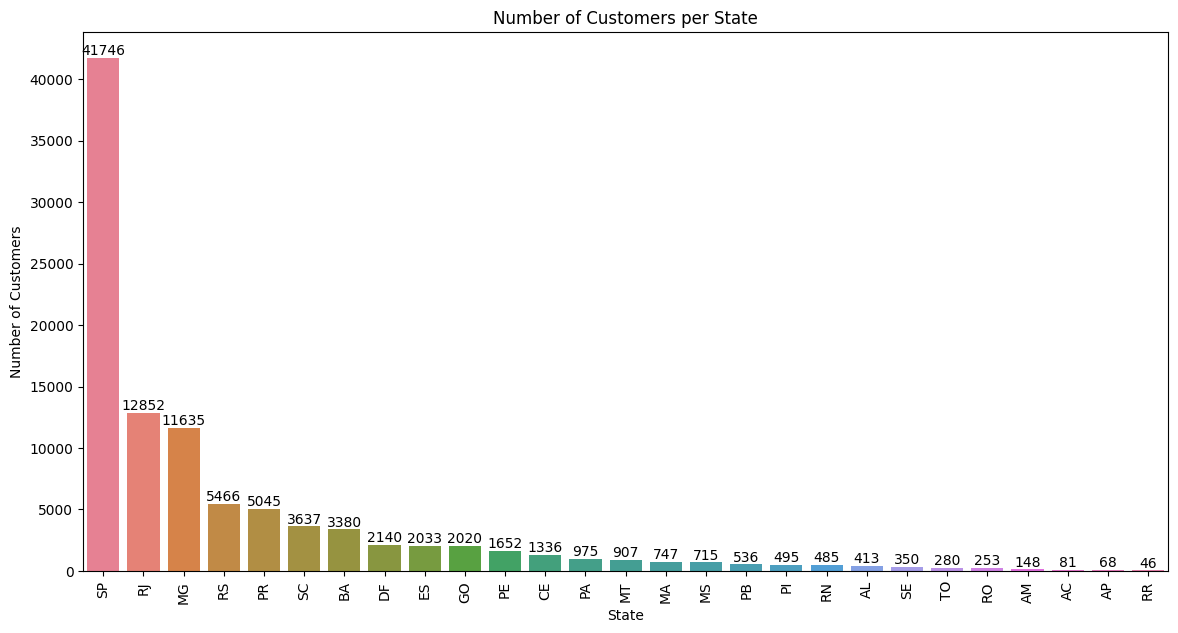

In [107]:
query = """ select customer_state,count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns=["State","Number of Customers"])
df=df.sort_values(by = "Number of Customers",ascending=False)
plt.figure(figsize=(14,7))
ax=sns.barplot(x=df["State"],y=df["Number of Customers"],data=df,hue=df["State"],legend=False)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.title("Number of Customers per State")
plt.show()

# 6. Calculate the `number of orders` per `month` in `2018`.

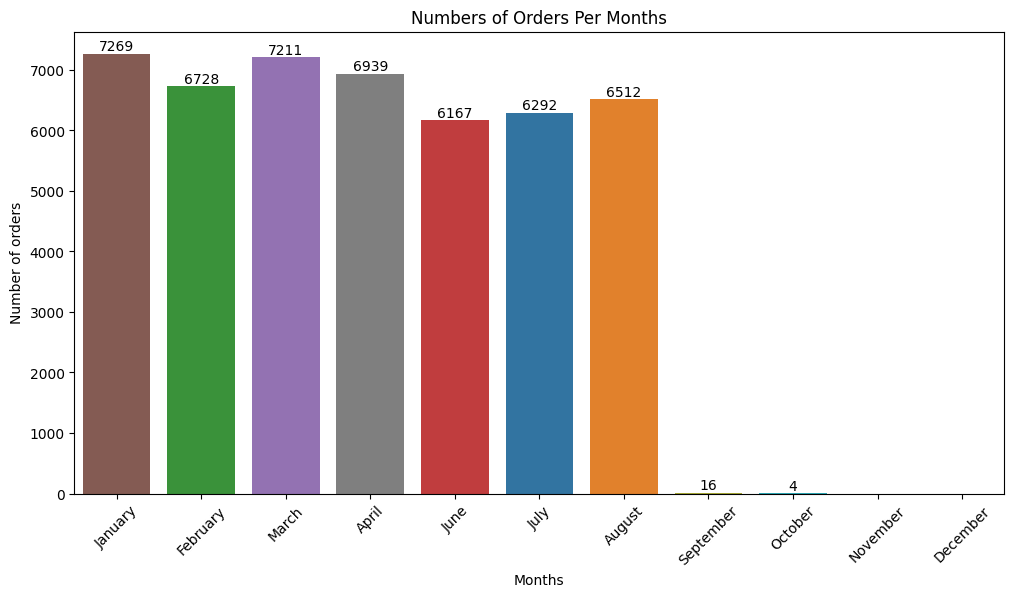

In [106]:
query = """ select monthname(order_purchase_timestamp) months,count(order_id)
from orders where year(order_purchase_timestamp)=2018
group by months
"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["Months","Number of orders"])

orde=["January","February","March","April","June","July","August","September","October","November","December"]
plt.figure(figsize=(12,6))
ax = sns.barplot(x=df["Months"],y=df["Number of orders"],data=df,order=orde,hue=df["Months"])

plt.xticks(rotation = 45 )
plt.title("Numbers of Orders Per Months")

for container in ax.containers:
    ax.bar_label(container)

plt.show()


# 7.Find the average number of products per `order`, grouped by `customer city`.

In [110]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select upper(customers.customer_city), round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer City", "Average Products/Order"])
df.head(10)

,Customer City,Average Products/Order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,DATAS,6.00
3,CANDIDO GODOI,6.00
4,MATIAS OLIMPIO,5.00
5,MORRO DE SAO PAULO,4.00
6,TEIXEIRA SOARES,4.00
7,CURRALINHO,4.00
8,CIDELANDIA,4.00
9,PICARRA,4.00
